# Introduction / Motivation

This idea came into my mind right after completing my [first notebook](https://www.kaggle.com/dardodel/steam-reviews-simpletransformers-classification) about this dataset, which was a classification model with SimpleTransformers. I thought that it would be very interesting to find the topics in the positive, negative or all comments. 

For this study, I focused on only the negative comments which are more interesting to me. What is wrong with this game? Why do people not like it? What can we do to remove throublesome bugs? In simple words, how can we improve the user experience The other reason that I picked just negative (or we could pick just positive) reviews was that the topic clustering quality would be increased when we focus only on one sentiment, specially when NLP/NLU models still struggle with negation or sarcasm complexity.  

For the topic modeling steps, I basically follow this fantastic [blog post](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) and don't talk about the very details as that blog post describes them very well. Thank you David for sharing your great work! I highly recommend to read through that post before dive into my notebook. However, I made small changes to the steps to make this approach more suitable for Steam dataset and improve the quality of topics. Please read the comments inside the code too.

Note that the pipeline you see in this notebook is very similar to that of [BERTopic](https://maartengr.github.io/BERTopic/api/bertopic.html). The difference is that with this pipeline you have extra control on the functions. You can easily modify them as wish (You will see many of those soon). The other key difference is the last step where BERTopic uses tf-IDF to build the cluster labels while, here, we use spaCy to find the word POS and, finally, concatenate the most common verb, direct object, and top two nouns from each cluster. This way the auto-generated topics will be more human readable (One of the most challenging steps of topic modeling). You will see the details at the end of this notebok.
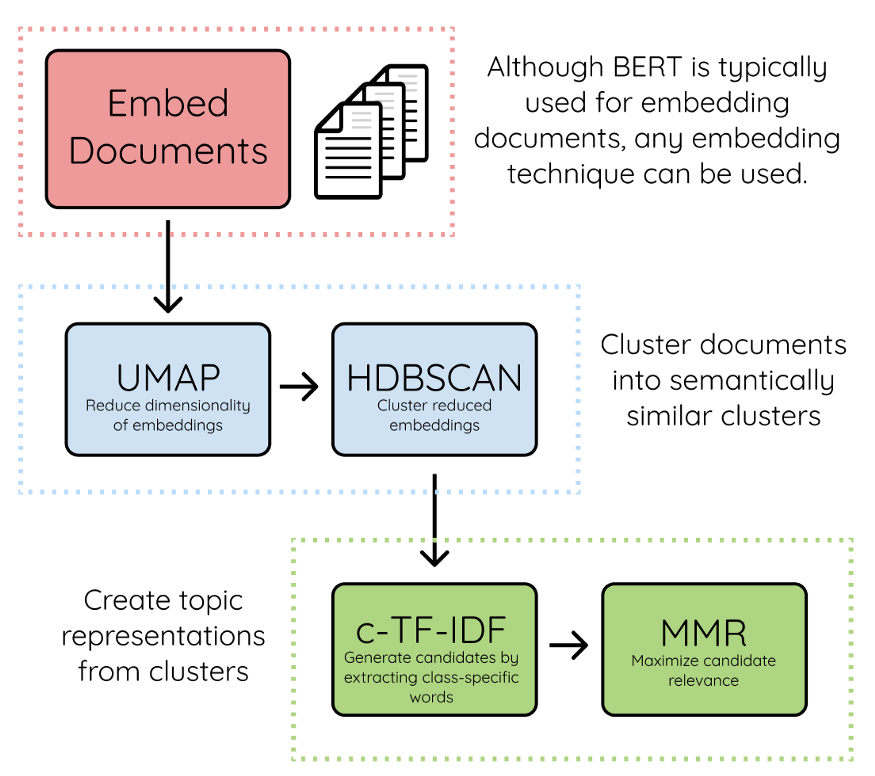
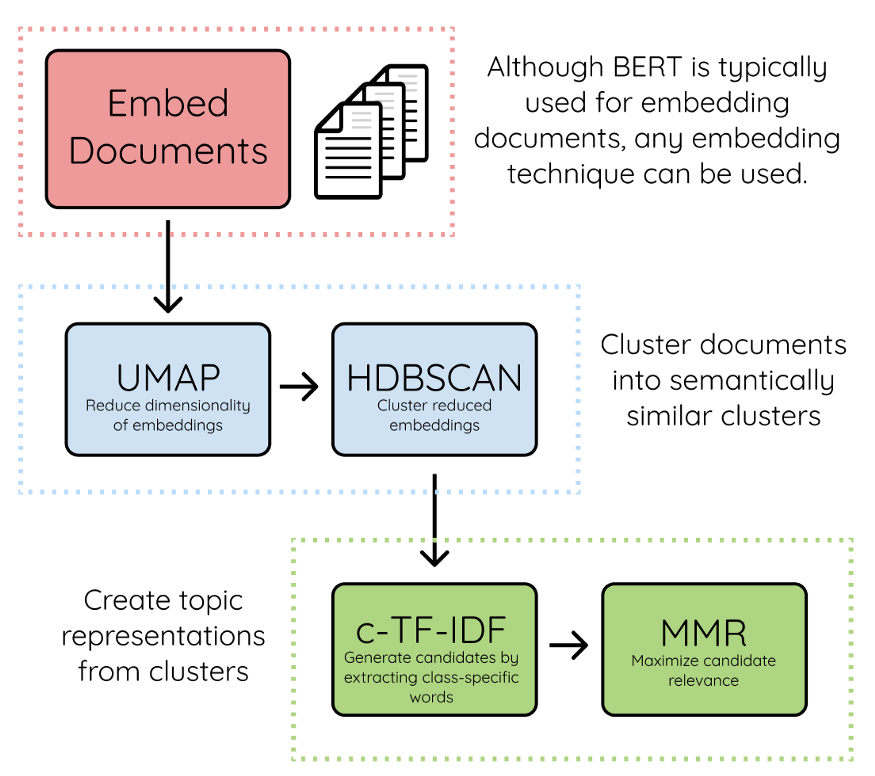
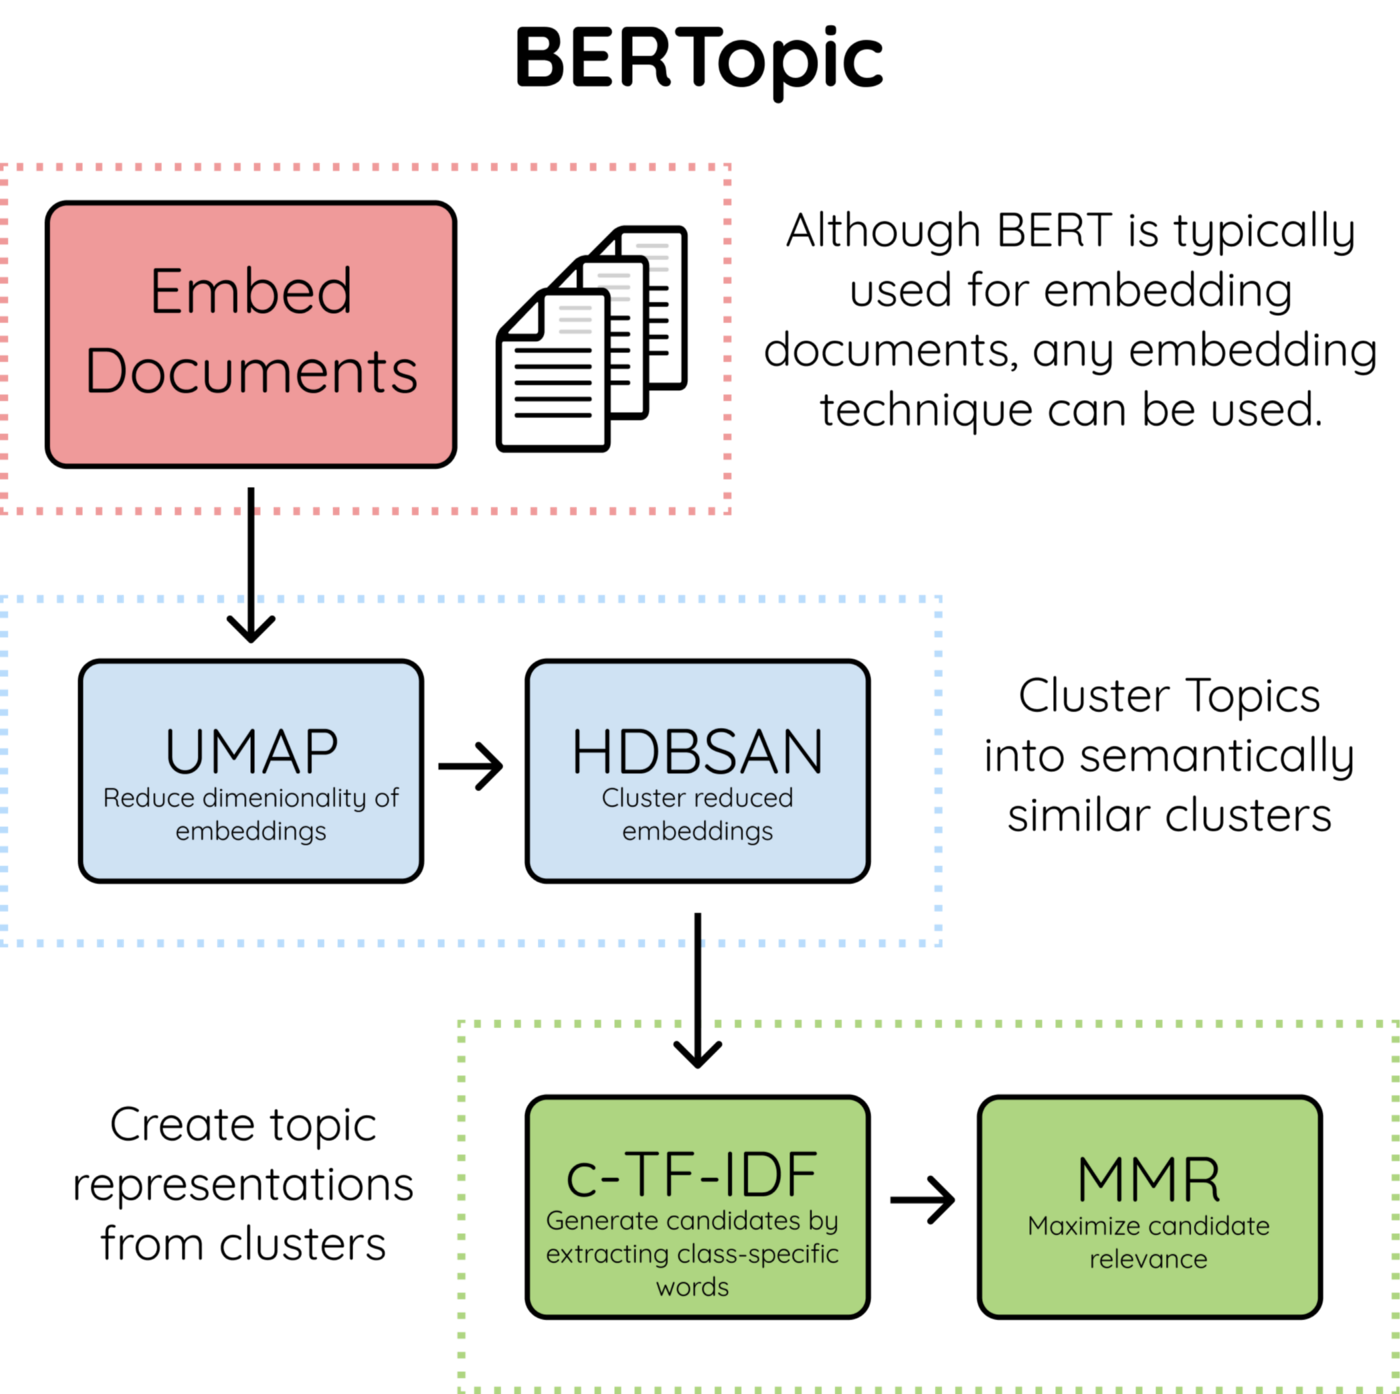

# Read and Prep Data
The original dataset is quite large. I only read a subset of rows for faster run.

In [1]:
import numpy as np 
import pandas as pd 
import random as rn
import re
import nltk
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [2]:
# nltk.download('punkt')

In [3]:
rn.seed(a=42)
p = 0.004  # to randomly select n% of the rows

df_reviews = pd.read_csv("dataset.csv", skiprows=lambda i: i > 0 and rn.random() > p)

# size of dataframe
print(df_reviews.shape)
display(df_reviews.head())


(25435, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,Hands down the GOAT.,1,1
2,10,Counter-Strike,good game visit my gorup and play on my cs server http://steamcommunity.com/groups/yuugaming,1,0
3,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
4,10,Counter-Strike,"Well if you think ♥♥♥♥♥♥ game,♥♥♥♥♥♥ graphics,♥♥♥♥♥iy weapons,you are a very crazy person.This game yes its an ♥♥♥♥♥♥ Game but its fun so no give any crap.Don't buy it on 9.99 dolars buy it on when sales like 2.49 and 4.99 dolars.Great game for relax.Recommending!",1,0


In [4]:
# convert review text to string
df_reviews["review_text"] = df_reviews["review_text"].astype(str)
df_reviews["review_votes"] = df_reviews["review_votes"].astype(str)
df_reviews.review_text = df_reviews.review_text.apply(lambda s: s.strip())

# drop the reviews with null score
df_reviews_2 = df_reviews[df_reviews["review_score"].notnull()]

# change the scores from 1, -1 to 1 and 0
df_reviews_2["review_score"] = \
np.where(df_reviews_2["review_score"]==-1, 0, df_reviews_2["review_score"])

In [5]:
## Let's remove the "Early Access Review" comments. 
# These are the reviews with no comments writen by a human/reviewer. 
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != "Early Access Review"]
df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]
print(df_reviews_2.shape)

# Drop duplicates if there is any
df_reviews_2.drop_duplicates(['review_text', 'review_score'], inplace = True)
print(df_reviews_2.shape)

(21425, 5)
(21197, 5)


I found that all of the F words and similar words (such as shit, etc.) are replaced by multiple "♥"s in the original text. This is a source of confusion to the model that we are going to use to get the text embeddings. Heart is a symbol of love while they appear in the negative comments, therefore, it will impact our classifier. I replace them with '****' which seems a token close to the F words. In my [other notebook](https://www.kaggle.com/dardodel/steam-reviews-simpletransformers-classification), I found that this step would improve the embedding accuracy. 

In [6]:
## Text Cleaning
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)
df_reviews_2['review_text_clean'] = df_reviews_2.review_text.apply(replace_hearts_with_PAD)

Let's select 2000 negative samples randomly. Using more data will take much more time and it is out of the scope of this notebook. 

In [7]:
neg_reviews = df_reviews_2[df_reviews_2.review_score == 0]
neg_reviews = neg_reviews.sample(n=2000, random_state = 1234)
all_intents = neg_reviews.review_text_clean.tolist()

print(neg_reviews.shape)
neg_reviews.head(2)

(2000, 6)


,app_id,app_name,review_text,review_score,review_votes,review_text_clean
4935,219740,Don't Starve,This is a fun game for a small amount of time unless you are a no lifer . I don't mean that as an insult to anyone it's just some people have more time than others ..like anyone with a job or kids or literally anything to do other than play video games will not have time for this game . I made the mistake of playing way to many hours only to never get past a few weeks because this game explain...,0,0,This is a fun game for a small amount of time unless you are a no lifer . I don't mean that as an insult to anyone it's just some people have more time than others ..like anyone with a job or kids or literally anything to do other than play video games will not have time for this game . I made the mistake of playing way to many hours only to never get past a few weeks because this game explain...
22189,443580,Antenna,Games looks nice but it has slow pace even for an adventure.,0,0,Games looks nice but it has slow pace even for an adventure.


Now the first difference between my work and this [blog post](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) is here, splitting the comments/reviews into sentences. Some of the Steam reviews are lengthy. It is not surprising to see multiple topics in one reviews. If we pass the whole lengthy comments through a sentence encoder, we will not see a nice and clean clustering outcome.

In this way we: 

1) Ignore noises and less-important sentences/phrases in one comment 

2) We handle multi topics better in one comment. 

Also, to remove noises, I include only the sentences with more than 4 words (5 and up). You can play with this threshold and explore the impacts. I would not recommend a threshold of 2 or smaller. 


## Split reviews into Sentences

nltk sent_tokenize function is used to split the sentences. 

In [8]:

all_sents = []
for intent in all_intents:
    for sent in nltk.sent_tokenize(intent):
        if len(sent.split()) > 4:
            all_sents.append(sent)
print(len(all_sents))            
all_intents = all_sents

9214


# Sentence Embedding

Install sentence-transformers package. We need it to get the sentence embedding vectors.

In [9]:
# for Sentence Transformer models
from sentence_transformers import SentenceTransformer
import tensorflow as tf

In [10]:
from torch.utils.data import TensorDataset, random_split

In [11]:
# To limit allocating the whole GPU memory by Pytorch run this cell. 
# Source: https://www.tensorflow.org/guide/gpu

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[This blog](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) found that among the follwoing transformer models, "all-mpnet-base-v2" results the best sentence embedding and consequently the best clustering outcome. In this notebook, I use the same model. It is an interesting exploration step to try other models (as well as Google Universal Sentence Encoder) and compare the results. 

In [12]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

model_st1 = SentenceTransformer('all-mpnet-base-v2')
# model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
# model_st3 = SentenceTransformer('all-distilroberta-v1')

embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
# embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
# embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

# Dimensionality Reduction & Clustering

It is recommended to reduce the dimension of sentence embeddings into a smaller dimensions before performing clustering. For more details see [this](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) or [this](https://bib.dbvis.de/uploadedFiles/155.pdf). For the dimensionality reduction we use [UMAP](https://umap-learn.readthedocs.io/en/latest/) technique. 

HDBSCAN method is used here for clustering which has benefits to the topic modeling. It has some features (like the probability score) that help us to automate the optimum number of clusters which is a big trouble in an unsupervised topic modeling. 

Let's install hdbscan package but make sure to install it ONLY in the follwoing way (do NOT pip install it) to avoid any error message and thank me later ;)

In [ ]:
import umap     # dimensionality reduction
import hdbscan  # clustering
from functools import partial

# To perform the Bayesian Optimization for searching the optimum hyperparameters,
# we use hyperopt package:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials


In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

# Use Bayesian Optimization with Hyperopt

Note that in the "objective" function I changed the penalty from 0.15 (used [here](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)) to 1.0. You may need to update it as you change the settings. For instance, if you use positive comments or read more than or less than 2000 comments, you need to adjust this penalty value. Remember that this is the penalty (or cost) we add to the cost function if the number of clusters go above or beyond our boundaries (here 10 and 100). 

In [ ]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05) # 0.05
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 1.0 #0.5 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In the following cell we define the space for hyperparameters search. Our reference [blog](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) used different ranges for search. I found that thie following ranges are better choices for Steam Reviews topic modeling. Feel free to experiment different ranges.

In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25 # change it to 50 or 100 for extra steps as you wish.

In [33]:
%%time
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

job exception: module 'umap' has no attribute 'UMAP'



  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]


AttributeError: module 'umap' has no attribute 'UMAP'

USe the following cell to print the sentences of a given cluster (C_)

In [ ]:
# C_ = 11
# for index, clust in enumerate(best_clusters_use.labels_):
#     if clust == C_:
#         print(all_intents[index])
#         print()

# Automatic cluster labeling

For the automatic cluster labeling, we use spacy library to get the words POS (part of speech). From each cluster, we concatenate the most common verb, direct object, and top two nouns to build the cluster topic/label. 

In [ ]:
import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
data_clustered = pd.DataFrame(data = list(zip(all_intents,best_clusters_use.labels_)),
                             columns = ['text', 'label_st1'])
data_clustered.head()

In [ ]:
# example_category = data_clustered[data_clustered['label_st1']==2].reset_index(drop=True)
# example_category.head() 

## Find the IDF of every word

This is a new step I introduce here (not seen in our [reference blog](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e)). As mentioned above, we pick the most common, verbs, nouns, etc. to build the cluster labels. But sometimes, the most common word/verb in a cluster is not the best choice. For example, for Steam reviews, we will see the words "play" or "game" in most of the clusters or comments. To blanace that, I use IDF part of tf-IDF idea. If a word appears in all clusters or all comments it is probably not that important (think of for example stop words ... they are everywhere. Are they that important to be in the cluster lable? No.) In contrast, if a word is not everywhere (in the majority of comments) we pay more attention to it. Later, when we look for the most common words, we give more weight to low-frequent words (and less weight to high-frequent words, which have lower IDF score).

To get the IDF score we could use "TfidfVectorizer" function from sklearn package. But I prefer to define my own function because of two main reasons:

1) TfidfVectorizer uses a special regex to find the words/tokens. I want to capture everything between two blank spaces, including all symbols or punctuations. 

2) IDF is the log((number of documents)/(number of documents the word appears in). I would like to try different functions other than log, or I would like to try differen log bases, such as 2, 10, or natural log, etc. 

Since later we will use the lemmetized and lowered version of words for cluster lebels, I re-generate the reviews with the lemmetized and lowered version of the words that we are interested in (verb, noun, adjectives, etc.). We use this list "sent_with_word_lemma" to find the IDF scores next. 

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

sent_with_word_lemma = []
for intent in all_intents:
    doc = nlp(intent)
    sent_temp = ""
    this_one = False
    for token in doc:
        if (token.pos_ in ['VERB', 'NOUN', 'ADJ']) or (token.dep_=='dobj'):
            sent_temp += token.lemma_.lower() + " "
    sent_with_word_lemma.append(sent_temp)

In [ ]:
def compute_IDF(documents):
    word_count = Counter()
    for doc in documents:
        if 'drops(players' in doc:
            print(doc)
            print(doc.split())
        words_set = set(doc.split())
        word_count.update(words_set)
    total = sum(word_count.values())
    return {k: round((np.log2(total / v)))  for k, v in word_count.items()} # log2 is the best choice for our work (feel free)
                                                                            # to try different functions.

word_IDF = compute_IDF(sent_with_word_lemma)

word_IDF is a dictionary whose keys are the words values are the IDF scores. 

## Helper Functions

I used all the helper functions from our [reference blog](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) with slight changes to the "most_common" and "extract_labels" functions.

In [ ]:
def get_group(df, category_col, category):
    """
    Returns documents of a single category
    
    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """
    
    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category 

def most_common(lst, n_words):
    """
    Get most common words in a list of words
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    
    for k in list(counter): 
        if counter[k] ==1: # if appears only once, ignore it.
            pass 
        else:
            counter[k] *= word_IDF[k] # if the word appears more than once in the entire cluser, 
                                      # repeat that word "IDF" times in our bag. If a word is 
                                      # low-frequent word it has a high IDF values, so, with this
                                      # technique we give more chance to this word to show up in 
                                      # the list of most common words
        
    return counter.most_common(n_words)

def extract_labels(category_docs, print_word_counts=False):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if (token.is_stop==False) and (len(str(token).strip()) > 0): 
                # ignore if it is a stop word or the length of stripped token is less than 1!
                if token.pos_ == 'VERB':
                    verbs.extend([token.lemma_.lower()]) 

                elif token.dep_=='dobj':
                    dobjs.extend([token.lemma_.lower()]) 

                elif token.pos_=='NOUN':
                    nouns.extend([token.lemma_.lower()]) 
                    
                elif token.pos_=='ADJ':
                    adjs.extend([token.lemma_.lower()])

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter=collections.Counter(word_lst)
            print(counter)
    
    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label

def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)['text'])
        label_dict[label] = extract_labels(current_category)
        
    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text':'count'})
                    .sort_values('count', ascending=False))
    
    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)
    
    return summary_df

#### Get the labels:

In [ ]:
cluster_summary = apply_and_summarize_labels(data_clustered, 'label_st1')
cluster_summary

The table above shows the cluster number, the number of samples in each and the suggested, auto-created labels (topics). I know, some of them are still vauge but I believe that, in general, it did a very good job! A domain expertise should step in and read a couple of samples from each cluster and modify the lable if needed. Unfortunately, I am not a gamer! and don't have much of knowledge about the games. Having such knowledge help us, specially, when the reviewer compares this game with other games or talks about the pros and cons of a game. However, I think I can clearly see the topics from this table. 

Some clusters talk about the resolution or the graphic of the game, or interestignly one cluster goes to the more details and covers the ftp (frame per second) aspect of it. We see some reviwers compare this game with others, or even recommend other games. Some believe that this is a boring game or even one cluster clearly shows the 4/10 score. A couple of clusters hover around the pricing or recommending to buy the game on the sale (since these are negative comments and people think this game is only worth to play/have with some discounts). I don't want to cover all topics here you can print the sentences of each cluster and compare the labels manually. If I want to add, I see few clusters clearly talks about the characters or the story of the game. Please go ahead and check out others yourself. 

In [ ]:
# C_ = 11
# for index, clust in enumerate(best_clusters_use.labels_):
#     if clust == C_:
#         print(all_intents[index])
#         print()